In [28]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 35.9 MB/s  0:00:00 eta 0:00:01


In [20]:
!pip install openpyxl

In [21]:
import pandas as pd

oct = pd.read_excel('october.xlsx', sheet_name=None)
nov = pd.read_excel('november.xlsx', sheet_name=None)
dec = pd.read_excel('december.xlsx', sheet_name=None)

In [26]:
from datetime import datetime, time

floor1 = ['Lobby/Atrium', 'Competition Pool', 'Instructional Pool', 'Spa',
          'Classroom 105', 'Spectator Seating', 'Classroom 120', 'MAC',
          'Golf Simulator', 'Climbing Wall', 'OA']

floor2 = ['2nd Floor Fitness', '2nd Floor Cardio Pool Side',
          '2nd Floor Cardio MAC Side', '2nd Floor Soft Seating',
          'MPR Mind Body', 'MPR Spin', 'MPR Functional Training',
          'MPR Group Fitness']

floor3 = ['3rd Floor Wood Courts', '3rd Floor Tennis Courts',
          '3rd Floor Fitness Area - Wood Side',
          '3rd Floor Fitness Area - Tennis Side',
          '3rd Floor Fitness Platforms']

floor4 = ['4th Floor FTA (Turf & Racks)', '4th Floor Fitness Queenax',
          '4th Floor Cardio MODs', 'Racquetball & Squash Courts', 'Track']


def parse_sheet_date(sheet_name):
    sheet_name = sheet_name.strip()
    # delete this sheet
    if sheet_name == "Template": # Special case
        return datetime(2025, 10, 1)
    if sheet_name == "1012025":  # Special case
        return datetime(2025, 10, 1)
    if sheet_name == "1112025":  # Special case
        return datetime(2025, 11, 1)
    if sheet_name == "1212025":  # Special case
        return datetime(2025, 12, 1)
    if len(sheet_name) == 3:  # e.g. "102" → October 2
        month = int(sheet_name[0]) + 9  # 10, 11, 12
        day = int(sheet_name[1:])
    elif len(sheet_name) == 4:  # e.g. "1209" → Dec 9
        month = int(sheet_name[:2])
        day = int(sheet_name[2:])
    else:
        raise ValueError(f"Cannot parse sheet name: {sheet_name}")
    return datetime(2025, month, day)


def clean_month(path):
    raw = pd.read_excel(path, sheet_name=None)
    cleaned_list = []

    for sheet_name, df in raw.items():
        date = parse_sheet_date(sheet_name)
        weekday = date.strftime("%A")
        if sheet_name == "Template":
            continue

        time_map = {'Unnamed: 0': 'Area',
                    'Unnamed: 1': '6.5',
                    'Unnamed: 2': '7.5',
                    'Unnamed: 3': '8.5',
                    'Unnamed: 4': '9.5',
                    'Unnamed: 5': '10.5',
                    'Unnamed: 6': '11.5',
                    'Unnamed: 7': '12.5',
                    'Unnamed: 8': '13.5',
                    'Unnamed: 9': '14.5',
                    'Unnamed: 10': '15.5',
                    'Unnamed: 11': '16.5',
                    'Unnamed: 12': '17.5',
                    'Unnamed: 13': '18.5',
                    'Unnamed: 14': '19.5',
                    'Unnamed: 15': '20.5',
                    'Unnamed: 16': '21.5',
                    'Unnamed: 17': '22.5',
                    'Unnamed: 18': '23.5',
                    'Unnamed: 19': 'Totals'
    }

        df = df.rename(columns=time_map)

        # Then first column is AREA
        df = df.rename(columns={df.columns[0]: 'AREA'})

        # Convert time columns to numeric
        time_cols = df.columns[1:]  # everything except AREA
        df[time_cols] = df[time_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

        # Compute floor totals
        floors = pd.DataFrame(columns=time_cols, index=["Floor 1", "Floor 2", "Floor 3", "Floor 4"])

        floors.loc["Floor 1"] = df[df["AREA"].isin(floor1)][time_cols].sum()
        floors.loc["Floor 2"] = df[df["AREA"].isin(floor2)][time_cols].sum()
        floors.loc["Floor 3"] = df[df["AREA"].isin(floor3)][time_cols].sum()
        floors.loc["Floor 4"] = df[df["AREA"].isin(floor4)][time_cols].sum()

        floors = floors.reset_index().rename(columns={"index": "floor"})

        # Melt into long form
        long = floors.melt(id_vars=["floor"], var_name="time", value_name="count")
        long["date"] = date
        long["weekday"] = weekday

        cleaned_list.append(long)
    
    return pd.concat(cleaned_list, ignore_index=True)

# ---------------------------------------------------------
# MAIN PIPELINE
# ---------------------------------------------------------
oct_df = clean_month("october.xlsx")
nov_df = clean_month("november.xlsx")
dec_df = clean_month("december.xlsx")

full = pd.concat([oct_df, nov_df, dec_df], ignore_index=True)

weekly_avg = (
    full.groupby(["weekday", "floor", "time"])["count"]
        .mean()
        .reset_index()
)

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekly_avg["weekday"] = pd.Categorical(weekly_avg["weekday"], categories=weekday_order, ordered=True)
weekly_avg = weekly_avg.sort_values(["weekday", "floor", "time"])

# ---------------------------------------------------------
# Print sample output
# ---------------------------------------------------------
print("FULL LONG DATA (first 10 rows):")
print(full.head(10), "\n")

print("WEEKLY AVERAGES (first 10 rows):")
print(weekly_avg.head(10))


FULL LONG DATA (first 10 rows):
     floor time count       date    weekday
0  Floor 1  6.5   4.0 2025-10-01  Wednesday
1  Floor 2  6.5  25.0 2025-10-01  Wednesday
2  Floor 3  6.5  33.0 2025-10-01  Wednesday
3  Floor 4  6.5  22.0 2025-10-01  Wednesday
4  Floor 1  7.5   1.0 2025-10-01  Wednesday
5  Floor 2  7.5  40.0 2025-10-01  Wednesday
6  Floor 3  7.5  60.0 2025-10-01  Wednesday
7  Floor 4  7.5  36.0 2025-10-01  Wednesday
8  Floor 1  8.5   6.0 2025-10-01  Wednesday
9  Floor 2  8.5  52.0 2025-10-01  Wednesday 

WEEKLY AVERAGES (first 10 rows):
   weekday    floor  time      count
76  Monday  Floor 1  10.5   4.846154
77  Monday  Floor 1  11.5   5.846154
78  Monday  Floor 1  12.5   6.230769
79  Monday  Floor 1  13.5   7.230769
80  Monday  Floor 1  14.5   8.769231
81  Monday  Floor 1  15.5   8.307692
82  Monday  Floor 1  16.5  12.538462
83  Monday  Floor 1  17.5  12.923077
84  Monday  Floor 1  18.5  16.307692
85  Monday  Floor 1  19.5   8.615385


In [33]:
# Remove Totals column
weekly_avg = weekly_avg[weekly_avg["time"] != "Totals"]

# Convert time to numeric (forces strings + times → floats or NaN)
weekly_avg["time"] = pd.to_numeric(weekly_avg["time"], errors="coerce")

# Drop anything that still failed
weekly_avg = weekly_avg.dropna(subset=["time"])

print(weekly_avg["time"].apply(type).value_counts())

time
<class 'float'>    504
Name: count, dtype: int64


In [34]:
def constant_arrival_model(x, r, g, alpha):
    """
    Computes x_{n+1} from x_n
    """
    return (r * x + g) / (1 + alpha * x)

In [42]:
from scipy.optimize import curve_fit

def fit_floor_model(df_floor):
    """
    df_floor must be time-ordered and contain column 'count'
    """
    x_n = df_floor["count"].values[:-1]
    x_next = df_floor["count"].values[1:]

    # Initial guesses (important!)
    p0 = [0.9, 5.0, 0.01]   # r, g, alpha

    # Bounds keep parameters physically reasonable
    bounds = (
        [0.0, 0.0, 0.0],    # lower bounds
        [100.0, 1000.0, 1.0]  # upper bounds
    )

    params, _ = curve_fit(
        constant_arrival_model,
        x_n,
        x_next,
        p0=p0,
        bounds=bounds,
        maxfev=10000
    )

    return {
        "r": params[0],
        "g": params[1],
        "alpha": params[2]
    }


In [43]:
results = []

for weekday in weekly_avg["weekday"].unique():
    for floor in ["Floor 1", "Floor 2", "Floor 3"]:

        df_sub = weekly_avg[
            (weekly_avg["weekday"] == weekday) &
            (weekly_avg["floor"] == floor)
        ].sort_values("time")

        # Need at least 2 points
        if len(df_sub) < 2:
            continue

        params = fit_floor_model(df_sub)

        results.append({
            "weekday": weekday,
            "floor": floor,
            **params
        })

params_df = pd.DataFrame(results)
print(params_df)

      weekday    floor         r             g         alpha
0      Monday  Floor 1  1.344838  7.063882e-01  4.700426e-02
1      Monday  Floor 2  0.771848  5.008136e+00  2.220267e-14
2      Monday  Floor 3  1.060205  3.464987e+00  2.856782e-03
3     Tuesday  Floor 1  0.914099  1.136692e+00  2.786751e-03
4     Tuesday  Floor 2  0.549936  1.116413e+01  4.837755e-19
5     Tuesday  Floor 3  0.824537  8.040307e+00  1.399623e-12
6   Wednesday  Floor 1  1.577540  2.742274e-10  5.372938e-02
7   Wednesday  Floor 2  0.694449  8.304340e+00  8.160868e-19
8   Wednesday  Floor 3  0.728058  1.241578e+01  1.783153e-13
9    Thursday  Floor 1  0.956001  1.021659e+00  7.904200e-03
10   Thursday  Floor 2  0.338617  1.717884e+01  8.849640e-04
11   Thursday  Floor 3  0.743762  1.005712e+01  9.624484e-15
12     Friday  Floor 1  1.268703  5.511866e-16  2.342149e-02
13     Friday  Floor 2  1.475203  3.670939e-12  2.257023e-02
14     Friday  Floor 3  1.163695  2.420550e-16  3.176433e-03
15   Saturday  Floor 1  

In [44]:
import numpy as np

def simulate_floor(df_floor, params):
    x = [df_floor["count"].iloc[0]]
    for _ in range(len(df_floor) - 1):
        x.append(
            constant_arrival_model(
                x[-1], params["r"], params["g"], params["alpha"]
            )
        )
    return np.array(x)

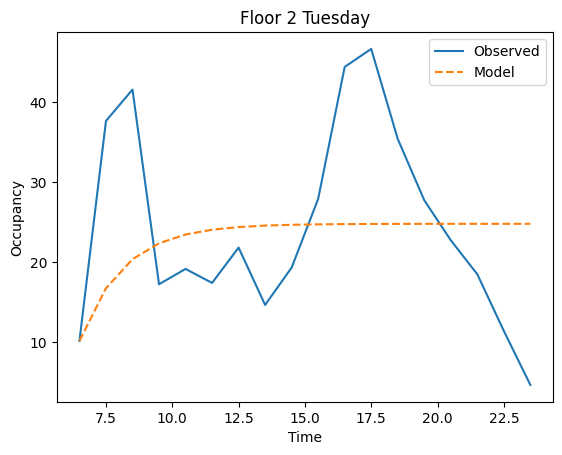

In [45]:
import matplotlib.pyplot as plt

day = "Tuesday"
floor = "Floor 2"

df_test = weekly_avg[
    (weekly_avg["weekday"] == day) &
    (weekly_avg["floor"] == floor)
].sort_values("time")

params = fit_floor_model(df_test)
x_hat = simulate_floor(df_test, params)

plt.plot(df_test["time"], df_test["count"], label="Observed")
plt.plot(df_test["time"], x_hat, label="Model", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Occupancy")
plt.legend()
plt.title(f"{floor} {day}")
plt.show()

Tune Parameters for all Models

In [46]:
import numpy as np

def simulate(x0, params, model, times):
    x = np.zeros(len(times))
    x[0] = x0

    for n in range(len(times) - 1):
        t = times[n]

        if model == "constant":
            g = params["g"]

        elif model == "one_peak":
            g = params["A"] + params["B"] * np.sin(
                2 * np.pi / 24 * (t - params["phi"])
            )

        elif model == "two_peak":
            g = (
                params["A"]
                + params["B"] * np.exp(-(t - params["mu1"])**2 / (2 * params["sigma1"]**2))
                + params["C"] * np.exp(-(t - params["mu2"])**2 / (2 * params["sigma2"]**2))
            )

        x[n+1] = (params["r"] * x[n] + g) / (1 + params["alpha"] * x[n])

    return x


In [47]:
from scipy.optimize import least_squares

def residuals(theta, x_obs, times, model):
    if model == "constant":
        r, g, alpha = theta
        params = dict(r=r, g=g, alpha=alpha)

    elif model == "one_peak":
        r, alpha, A, B, phi = theta
        params = dict(r=r, alpha=alpha, A=A, B=B, phi=phi)

    elif model == "two_peak":
        r, alpha, A, B, C, mu1, mu2, sigma1, sigma2 = theta
        params = dict(
            r=r, alpha=alpha, A=A, B=B, C=C,
            mu1=mu1, mu2=mu2, sigma1=sigma1, sigma2=sigma2
        )

    x_hat = simulate(x_obs[0], params, model, times)
    return x_hat - x_obs

In [ ]:
def fit_floor_model(df, model):
    times = pd.to_numeric(df["time"], errors="coerce").astype(float).values
    x_obs = pd.to_numeric(df["count"], errors="coerce").astype(float).values

    mask = np.isfinite(times) & np.isfinite(x_obs)
    times = times[mask]
    x_obs = x_obs[mask]

    if len(x_obs) < 2:
        raise ValueError("Not enough valid data points after cleaning")

    if model == "constant":
        theta0 = [0.9, np.mean(x_obs), 0.01]
        bounds = ([0, 0, 0], [2, np.inf, 1])

    elif model == "one_peak":
        theta0 = [0.9, 0.01, np.mean(x_obs), 10, 15]
        bounds = (
            [0, 0, 0, 0, 0],
            [2, 1, np.inf, np.inf, 24]
        )

    elif model == "two_peak":
        theta0 = [0.9, 0.01, 5, 20, 20, 9, 18, 2, 2]
        bounds = (
            [0, 0, 0, 0, 0, 6, 12, 0.5, 0.5],
            [2, 1, np.inf, np.inf, np.inf, 14, 22, 6, 6]
        )

    res = least_squares(
        residuals,
        theta0,
        bounds=bounds,
        args=(x_obs, times, model)
    )

    return res.x

In [53]:
results = []

for weekday in weekly_avg["weekday"].unique():
    for floor in ["Floor 1", "Floor 2", "Floor 3"]:

        df_sub = weekly_avg[
            (weekly_avg["weekday"] == weekday) &
            (weekly_avg["floor"] == floor)
        ].sort_values("time")

        if len(df_sub) < 5:
            continue

        for model in ["constant", "one_peak", "two_peak"]:
            theta = fit_floor_model(df_sub, model)

            results.append({
                "weekday": weekday,
                "floor": floor,
                "model": model,
                "params": theta
            })

params_df = pd.DataFrame(results)
print(params_df.head())


  weekday    floor     model  \
0  Monday  Floor 1  constant   
1  Monday  Floor 1  one_peak   
2  Monday  Floor 1  two_peak   
3  Monday  Floor 2  constant   
4  Monday  Floor 2  one_peak   

                                              params  
0  [1.7123783492182276, 1.6999070267098767e-16, 0...  
1  [0.926088071853218, 3.2954286557708753e-25, 7....  
2  [0.7488550225639614, 3.897584429279075e-21, 1....  
3  [1.9999942106090887, 25.808571136905744, 0.090...  
4  [7.827305700797445e-31, 0.12422890185225934, 7...  


In [54]:
def predict_from_theta(df, theta, model):
    times = pd.to_numeric(df["time"], errors="coerce").astype(float).values
    x_obs = pd.to_numeric(df["count"], errors="coerce").astype(float).values

    # Clean
    mask = np.isfinite(times) & np.isfinite(x_obs)
    times = times[mask]
    x_obs = x_obs[mask]

    if model == "constant":
        r, g, alpha = theta
        params = dict(r=r, g=g, alpha=alpha)

    elif model == "one_peak":
        r, alpha, A, B, phi = theta
        params = dict(r=r, alpha=alpha, A=A, B=B, phi=phi)

    elif model == "two_peak":
        r, alpha, A, B, C, mu1, mu2, sigma1, sigma2 = theta
        params = dict(
            r=r, alpha=alpha, A=A, B=B, C=C,
            mu1=mu1, mu2=mu2, sigma1=sigma1, sigma2=sigma2
        )

    x_hat = simulate(x_obs[0], params, model, times)
    return times, x_obs, x_hat

In [55]:
import matplotlib.pyplot as plt

def plot_fit(df, theta, model, weekday, floor):
    times, x_obs, x_hat = predict_from_theta(df, theta, model)

    plt.figure(figsize=(8, 4))
    plt.plot(times, x_obs, marker="o", linestyle="-", label="Observed")
    plt.plot(times, x_hat, linestyle="--", label="Fitted")

    plt.xlabel("Time (hours)")
    plt.ylabel("Occupancy")
    plt.title(f"{weekday} – {floor} – {model}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


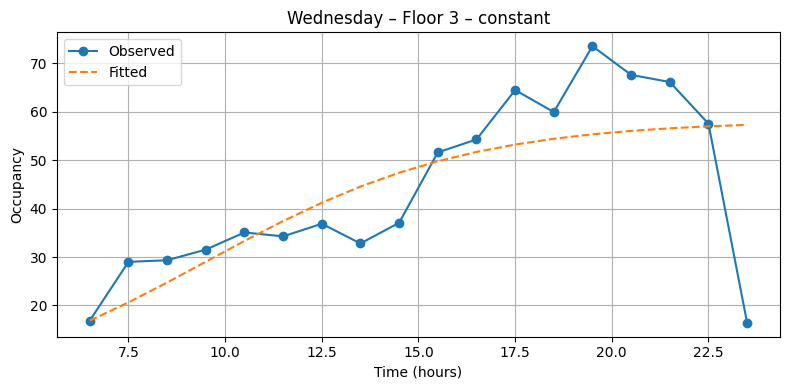

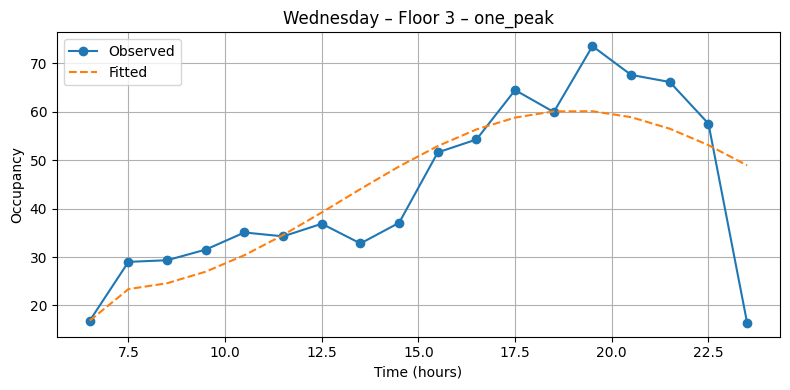

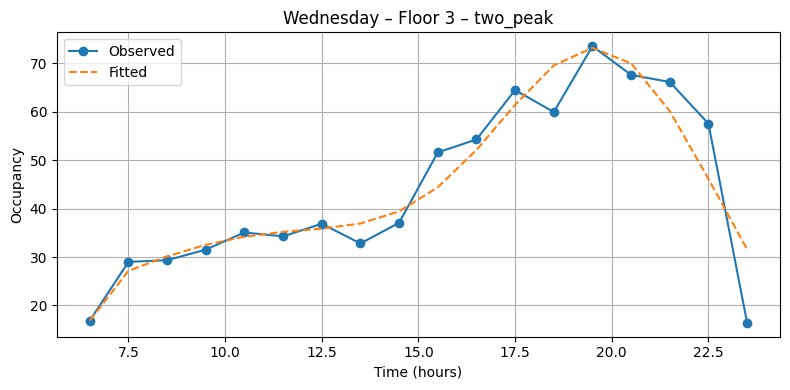

In [56]:
weekday = "Wednesday"
floor = "Floor 3"

df_sub = weekly_avg[
    (weekly_avg["weekday"] == weekday) &
    (weekly_avg["floor"] == floor)
].sort_values("time")

for model in ["constant", "one_peak", "two_peak"]:
    theta = fit_floor_model(df_sub, model)
    plot_fit(df_sub, theta, model, weekday, floor)